# Water mass transformation budgets for the SPNA

Water mass transformation budgets for three regions in the SPNA between CORE II runs of `EC30to60E2r2` and `oRRS18to6v3`

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import yaml
import sys
import geojson
from scipy import signal
from matplotlib import pyplot as plt, patches, colors
from cartopy import crs, feature
from fastjmd95 import rho
from tqdm import tqdm

# Import modules from path
sys.path.append('../modules/')
import postprocesstools as pptools
import watermasstools as wmttools
import calc_transformation_budget as trtools

# Set plot font sizes
plt.rcParams.update({'font.size': 13, 'axes.titlesize': 'medium'})

***

### Create mask files

Start by creating custom geojson files and name them according to region

In [2]:
# Regions
regions = ['Irminger_Iceland_Rockall', 'Nordic_Seas'] # 'Labrador_Sea', 

In [2]:
# Regions
regions = [
    'greenland_sea', 'irminger_iceland_basins', 'nordic_seas',
    'iceland_basin', 'iceland_rockall', 'irminger_sea', 'norwegian_sea',
    'iceland_sea', 'labrador_sea', 'rockall_trench',
]

Load each region into a `geojson.FeatureCollection`

In [3]:
# Load regions from geojson
fc = []
for region in regions:
    with open(f'../geojson/{region}.geojson') as f:
        fc.append(geojson.load(f)['features'][0])
fc = geojson.FeatureCollection(fc)

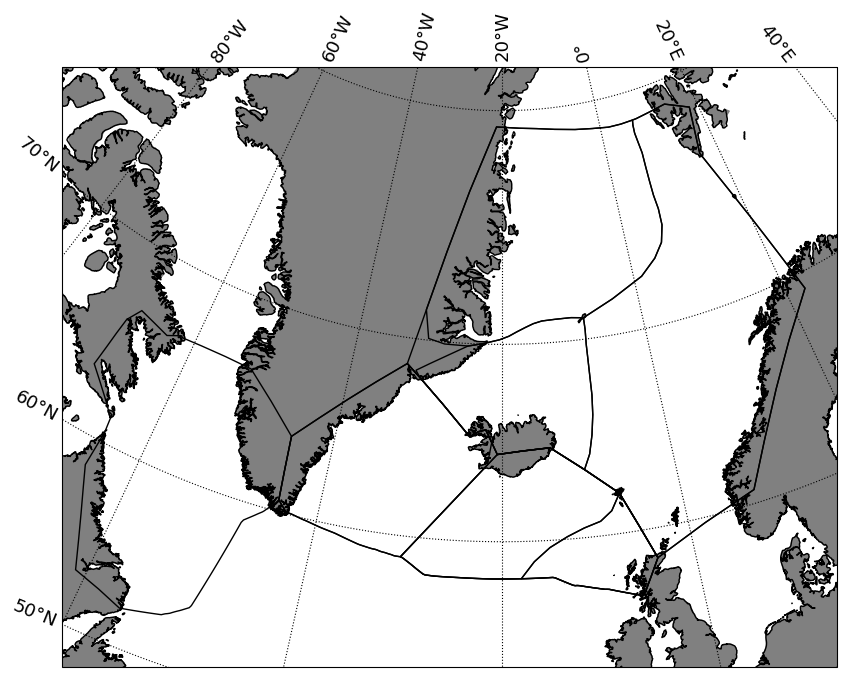

In [4]:
# Make map figure
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': crs.LambertConformal(-20, 70)})
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
palette = plt.get_cmap('tab10').colors
ax.set_extent([-60, 10, 50, 80])
ax.coastlines(resolution='10m')
ax.add_feature(feature.LAND, color='gray')
gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=range(-80, 41, 20), x_inline=False,
    ylocs=range(50, 81, 10), y_inline=False,
)
gl.bottom_labels, gl.right_labels = False, False

# Add polygons
proj_ref = crs.PlateCarree()
for feat in fc['features']:
    xy = np.array(feat['geometry']['coordinates'][0])
    ax.add_patch(patches.Polygon(xy, transform=proj_ref, fill=False))

Quick plot to visualize regions

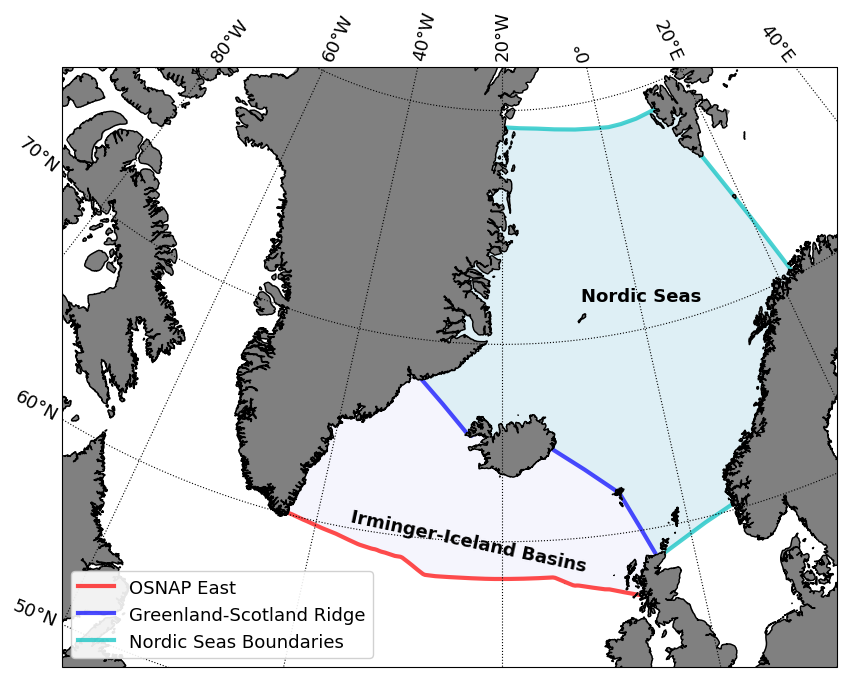

In [17]:
# Make map figure
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': crs.LambertConformal(-20, 70)})
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
palette = plt.get_cmap('tab10').colors
ax.set_extent([-60, 10, 50, 80])
ax.coastlines(resolution='10m')
ax.add_feature(feature.LAND, color='gray')
gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=range(-80, 41, 20), x_inline=False,
    ylocs=range(50, 81, 10), y_inline=False,
)
gl.bottom_labels, gl.right_labels = False, False

# Add polygons
proj_ref = crs.PlateCarree()
features = [feat for feat in fc['features'] if feat['properties']['name'] in ('Irminger-Iceland Basins', 'Nordic Seas')]
for feat, color in zip(features, ['lavender', 'lightblue']):
    xy = np.array(feat['geometry']['coordinates'][0])
    ax.add_patch(patches.Polygon(xy, transform=proj_ref, fc=color, alpha=0.4, zorder=-10))

xy = np.array(features[0]['geometry']['coordinates'][0])
xy_osnap, xy_GS = xy[6:177, :], xy[177:, :]
xy = np.array(features[1]['geometry']['coordinates'][0])
xy_nordic = xy[2:27, :]

for xy, color, label in zip([xy_osnap, xy_GS, xy_nordic], ['r', 'b', 'c'], ['OSNAP East', 'Greenland-Scotland Ridge', 'Nordic Seas Boundaries']):
    ax.plot(*list(xy.T), '-', color=color, lw=3, transform=proj_ref, label=label, alpha=0.7, zorder=-10)

ax.text(0.67, 0.61, 'Nordic Seas', transform=ax.transAxes, weight='bold')
ax.text(0.37, 0.16, 'Irminger-Iceland Basins', transform=ax.transAxes, weight='bold', rotation=-12)
ax.legend(loc=3, framealpha=0.9)
#fig.savefig('/pscratch/sd/b/bmoorema/posterfigs/transformation_regions.pdf', bbox_inches='tight')

Write `FeatureCollection` to combined geojson file, and run `MpasMaskCreator.x` to get a corresponding mask file for each mesh.

In [5]:
mask_path = '/pscratch/sd/b/bmoorema/maskfiles/'
with open(mask_path + 'transformation_budget_regions2.geojson', 'w') as f:
    f.write(geojson.dumps(fc, sort_keys=False, indent=4))

***

### Define region boundaries

Next we need a way of identifying the region open boundaries and normal velocity signs. Also, we need to identify which is the poleward boundary and which is the equatorward boundary. Here's a function based on code from Alice to do that `trtools.get_region_edges`.

Load mesh and mask variables

In [6]:
# Load EC30to60E2r2 mesh and newly-created maskfile
with open('../yaml/paths_LR.yaml') as f:
    paths = yaml.safe_load(f)

# Load mask variables
with xr.open_dataset(paths['maskfile']) as ds:
    regionNames = ds.regionNames.values.astype(str)
    regionMasks = ds.regionCellMasks.values

# Load mesh variables
with xr.open_dataset(paths['meshfile']) as ds:
    lonEdge = np.rad2deg(ds.lonEdge.values)
    latEdge = np.rad2deg(ds.latEdge.values)
    cellsOnEdge = ds.cellsOnEdge.values - 1
    lonEdge[lonEdge > 180] = lonEdge[lonEdge > 180] - 360

Test the boundary-finding function

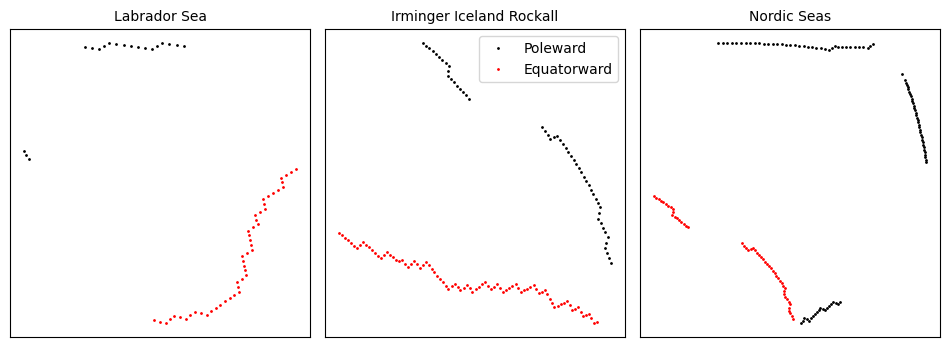

In [9]:
# Make figure
fig, axs = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.05})

# Loop through regions
for ax, regionName, regionMask in zip(axs, regionNames, regionMasks.T):
    
    # Find region edges, signs and poleward index
    edges, signs, ipoleward = trtools.get_region_edges(regionName, regionMask, cellsOnEdge, lonEdge, latEdge)
    
    # Plot edges
    lon, lat = lonEdge[edges], latEdge[edges]
    ax.plot(lon[ipoleward], lat[ipoleward], 'ko', ms=1, label='Poleward')
    ax.plot(lon[~ipoleward], lat[~ipoleward], 'ro', ms=1, label='Equatorward')

    # Formatting
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_title(regionName)

axs[1].legend(loc=1)

***

### Calculate air/sea water mass transformation

run `calc_transformation_budget.py`

In [2]:
results_path = '/pscratch/sd/b/bmoorema/results/aggregated/transformation/'
wmt = {}
for mesh in ['LR', 'HR']:
    wmt[mesh] = {}
    for decade in ['1947-1957', '1997-2007']:
        wmt[mesh][decade] = xr.open_dataset(results_path + f'transformationbudget_{mesh}_{decade}.nc')

In [3]:
def lowpass(x, windowsize=10):
    """Lowpass filter
    """
    
    # Lowpass filter
    window = signal.windows.blackman(windowsize)
    y = np.convolve(x, window / sum(window), mode='same')
    
    return y


def plot_transformation_stats(ax, x, y, c, label):
    """
    """
    
    y = y.resample(time='1Y').mean()
    stats = [lowpass(np.percentile(y, p, axis=0)) for p in (50, 1, 99)]
    ax.fill_between(sigma, *stats[1:], fc=c, ec=c, alpha=0.3)
    ax.plot(sigma, stats[0], '-', color=c, label=label)

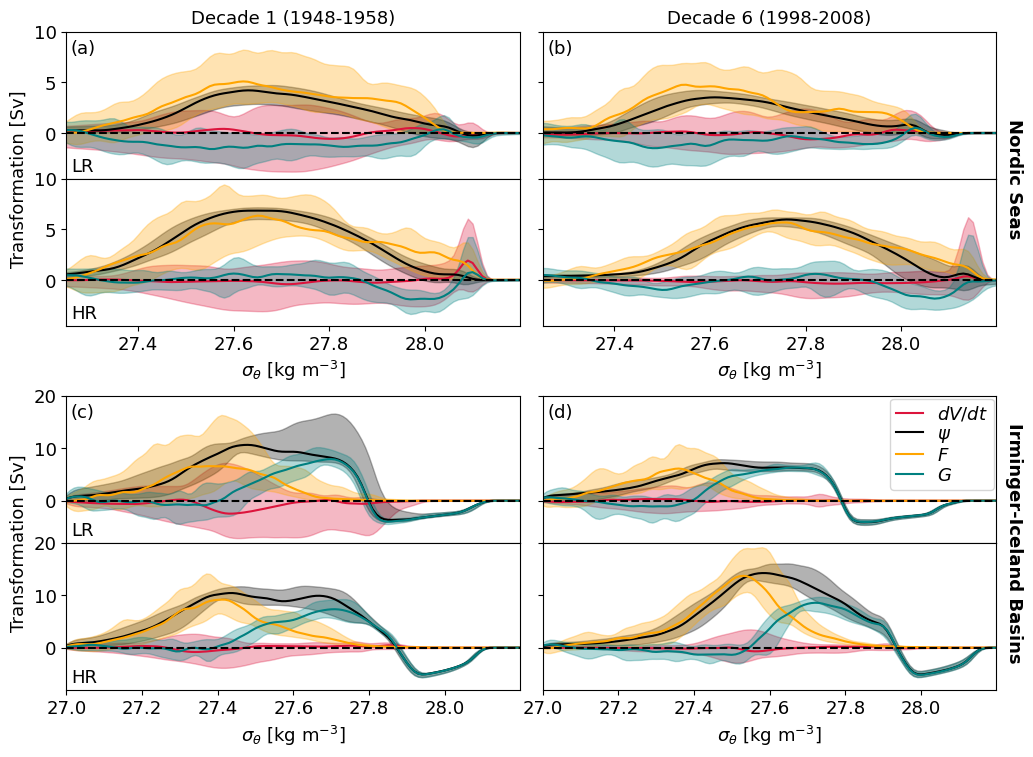

In [4]:
# Make figure
fig, axs = plt.subplots(4, 2, figsize=(12, 9), gridspec_kw={'wspace': 0.05, 'hspace': 0.24})
palette = ['crimson', 'gold', 'c', 'k']
bboxes = [(27.25, 28.199, -4.5, 10), (27, 28.199, -8, 20)]

regions = ['Nordic Seas', 'Irminger Iceland Rockall']
transects = [('Fram+Barents+NS', 'Iceland-Scotland'), ('Iceland-Scotland', 'OSNAP East')]
titles = ['Nordic Seas', 'Irminger-Iceland Basins']

# Loop through panels and transformation categories
k = 0
for col, decade, decade_label in zip(axs.T, ['1947-1957', '1997-2007'], ['1 (1948-1958)', '6 (1998-2008)']):
    col[0].set_title(f'Decade {decade_label}')
    for panel, region, transect, bbox, title in zip([col[:2], col[2:]], regions, transects, bboxes, titles):

        for ax, mesh in zip(panel, ['LR', 'HR']):

            # Sigma
            sigma = wmt[mesh][decade].sigmaBins

            # Plot volume tendency
            dVdt = wmt[mesh][decade]['volume'].sel(regionNames=region).diff(dim='time') / (86400 * 30) * 1e3
            dVdt = dVdt[:, ::-1].cumsum(dim='sigmaBins')[:, ::-1]
            plot_transformation_stats(ax, sigma, dVdt, 'crimson', '$dV/dt$')

            # Plot overturning transformation
            psi = []
            for tsect in transect:
                psi.append(wmt[mesh][decade].overturningTransformation.sel(transectNames=tsect))
            psi = np.subtract(*psi)
            plot_transformation_stats(ax, sigma, psi, 'k', '$\\psi$')

            # Plot air/sea transformation
            F = wmt[mesh][decade].totalTransformation.sel(regionNames=region)
            plot_transformation_stats(ax, sigma, F, 'orange', '$F$')

            # Plot mixing residual
            plot_transformation_stats(ax, sigma, psi-F+dVdt, 'teal', '$G$')

            # Formatting
            ax.plot(bbox[:2], [0, 0], 'k--')
            ax.set_xlim(bbox[:2])
            ax.set_ylim(bbox[2:])
            if decade == '1947-1957':
                ax.text(0.01, 0.05, mesh, transform=ax.transAxes)
            else:
                ax.yaxis.set_ticklabels('')
            if mesh == 'HR':
                pos = ax.get_position()
                ax.set_position([pos.x0, pos.y0+0.039, pos.width, pos.height])
                ax.set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
                if decade == '1947-1957':
                    ax.set_ylabel('Transformation [Sv]', y=1)
                else:
                    ax.text(1.02, 1, title, va='center', fontweight='bold', rotation=-90, transform=ax.transAxes)
                    #ax.text(0.92, -0.2, '$\\sigma_{\\theta}$ [kg m$^{-3}$]', transform=ax.transAxes)
            else:
                ax.xaxis.set_ticklabels('')

# Final formatting
for k, ax in enumerate(axs[[0, 2], :].ravel()):
    ax.text(0.01, 0.85, f'({chr(97+k)})', transform=ax.transAxes)
axs[2, 1].legend(loc=1, handlelength=1.5, labelspacing=0.1, borderpad=0.3, borderaxespad=0.15)
#fig.savefig('/pscratch/sd/b/bmoorema/posterfigs/transformation_budget.pdf', bbox_inches='tight')

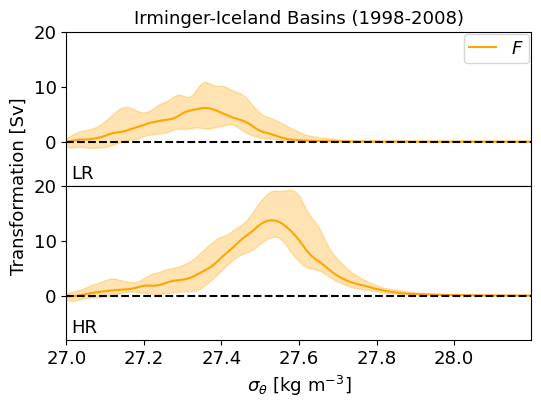

In [5]:
# Make figure
fig, axs = plt.subplots(2, 1, figsize=(6, 4), gridspec_kw={'hspace': 0.0})
palette = ['crimson', 'gold', 'c', 'k']
bboxes = [(27.25, 28.199, -4.5, 10), (27, 28.199, -8, 20)]

regions = ['Nordic Seas', 'Irminger Iceland Rockall']
transects = [('Fram+Barents+NS', 'Iceland-Scotland'), ('Iceland-Scotland', 'OSNAP East')]
titles = ['Nordic Seas', 'Irminger-Iceland Basins']

# Loop through panels and transformation categories
decade = '1947-1957'
region = 'Irminger Iceland Rockall'
transect = ('Iceland-Scotland', 'OSNAP East')
title = 'Irminger-Iceland Basins (1998-2008)'
bbox = (27, 28.199, -8, 20)

for ax, mesh in zip(axs, ['LR', 'HR']):

    # Sigma
    sigma = wmt[mesh][decade].sigmaBins

    # Plot volume tendency
    #dVdt = wmt[mesh][decade]['volume'].sel(regionNames=region).diff(dim='time') / (86400 * 30) * 1e3
    #dVdt = dVdt[:, ::-1].cumsum(dim='sigmaBins')[:, ::-1]
    #plot_transformation_stats(ax, sigma, dVdt, 'crimson', '$dV/dt$')

    # Plot overturning transformation
    #psi = []
    #for tsect in transect:
    #    psi.append(wmt[mesh][decade].overturningTransformation.sel(transectNames=tsect))
    #psi = np.subtract(*psi)
    #plot_transformation_stats(ax, sigma, psi, 'k', '$\\psi$')

    # Plot air/sea transformation
    F = wmt[mesh][decade].totalTransformation.sel(regionNames=region)
    plot_transformation_stats(ax, sigma, F, 'orange', '$F$')

    # Plot mixing residual
    #plot_transformation_stats(ax, sigma, psi-F+dVdt, 'teal', '$D$')

    # Formatting
    ax.plot(bbox[:2], [0, 0], 'k--')
    ax.set_xlim(bbox[:2])
    ax.set_ylim(bbox[2:])
    ax.text(0.01, 0.05, mesh, transform=ax.transAxes)
    if mesh == 'HR':
        ax.set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
        ax.set_ylabel('Transformation [Sv]', y=1)
    else:
        ax.xaxis.set_ticklabels('')

# Final formatting
axs[0].set_title(title)
axs[0].legend(loc=1, handlelength=1.5, labelspacing=0.1, borderpad=0.3, borderaxespad=0.15)

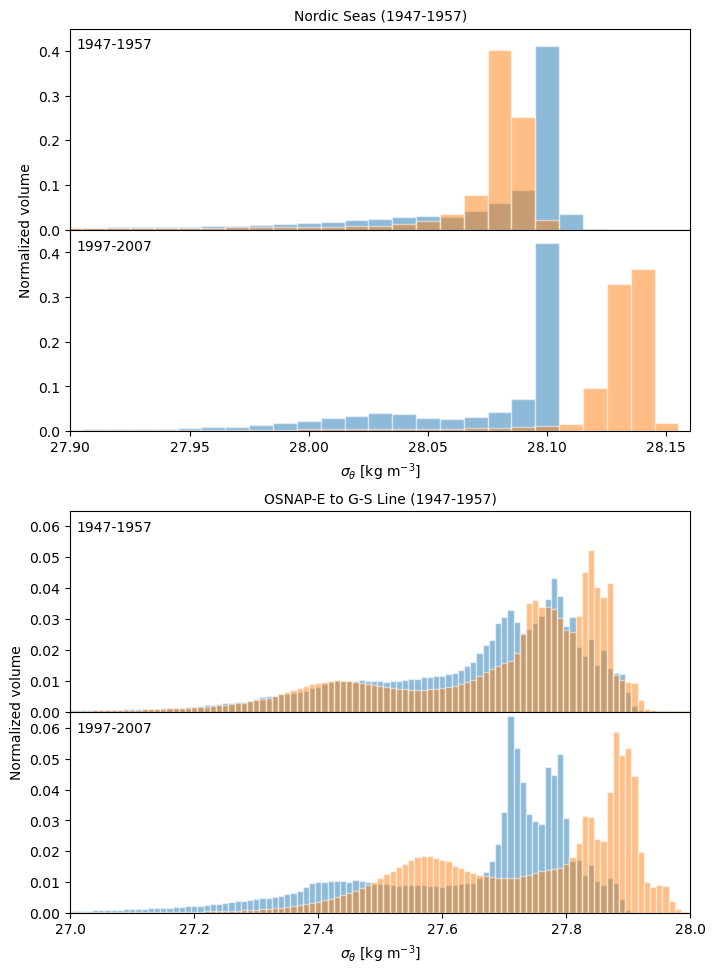

In [32]:
# Make figure
fig, axs = plt.subplots(4, 1, figsize=(8, 12))
palette = plt.get_cmap('tab10').colors
bboxes = [(27.9, 28.16, 0, 0.45), (27, 28, 0, 0.065)]

regions = ['Nordic Seas', 'Irminger Iceland Rockall']
titles = ['Nordic Seas', 'OSNAP-E to G-S Line']

# Loop through panels and transformation categories
for panel, region, bbox, title in zip([axs[:2], axs[2:]], regions, bboxes, titles):
    for ax, decade in zip(panel, ['1947-1957', '1997-2007']):
        for mesh, color in zip(['LR', 'HR'], palette):

            # Sigma
            sigma = wmt[mesh][decade].sigmaBins
            V = wmt[mesh][decade]['volume'].sel(regionNames=region).mean(dim='time')
            ax.bar(sigma, V / V.sum(), width=0.01, ec='w', alpha=0.5)
            
        # Formatting
        ax.set_xlim(bbox[:2])
        ax.set_ylim(bbox[2:])
        ax.text(0.01, 0.9, decade, transform=ax.transAxes)
        if decade == '1997-2007':
            pos = ax.get_position()
            ax.set_position([pos.x0, pos.y0+0.033, pos.width, pos.height])
            ax.set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
            ax.set_ylabel('Normalized volume', y=1)
        else:
            ax.set_title(f'{title} ({decade})')
            ax.xaxis.set_ticklabels('')

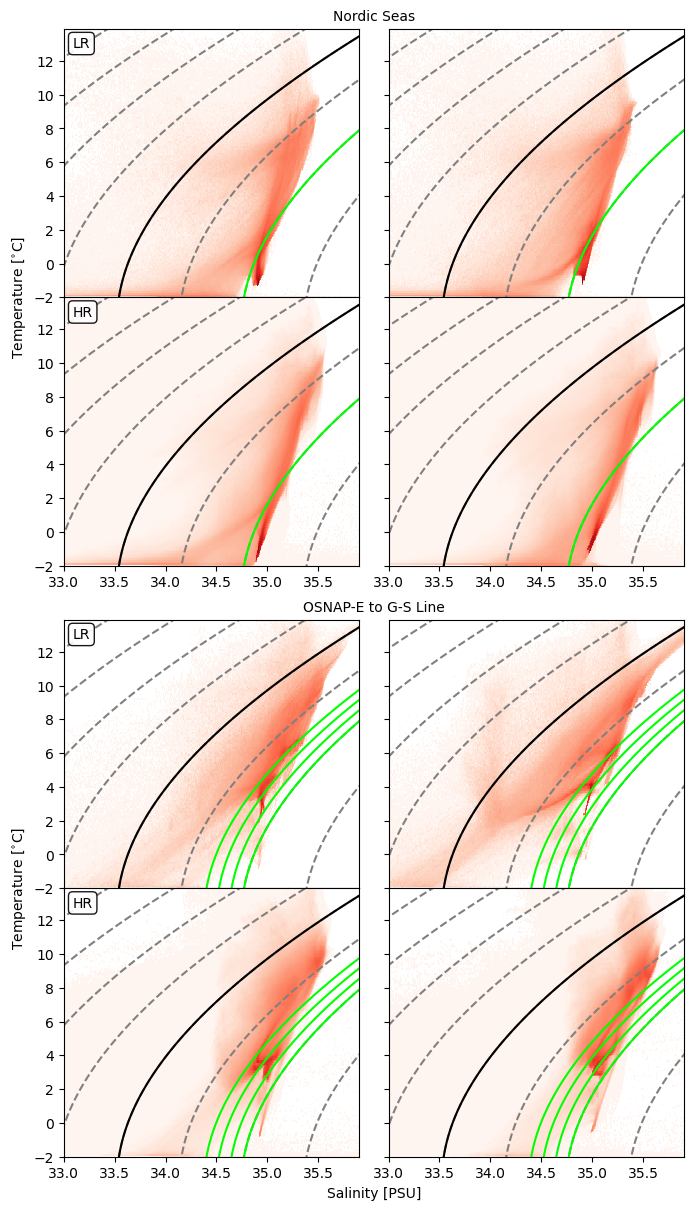

In [91]:
S, T = [wmt[mesh][decade][name] for name in ('salinityBins', 'temperatureBins')]
Sgrid, Tgrid = np.meshgrid(S, T)
sigma = rho(Sgrid, Tgrid, 0) - 1000
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}

# Plot volume and density
fig, axs = plt.subplots(4, 2, figsize=(8, 15), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
xlim, ylim = [33, 35.9], [-2, 13.9]

regions = ['Nordic Seas', 'Irminger Iceland Rockall']
transects = [('Fram+Barents+NS', 'Iceland-Scotland'), ('Iceland-Scotland', 'OSNAP East')]

for col, decade in zip(axs.T, ['1947-1957', '1997-2007']):

    for panel, region in zip([col[:2], col[2:]], regions):
        
        for ax, mesh in zip(panel, ['LR', 'HR']):

            volume = wmt[mesh][decade].volumetricTS.sel(regionNames=region).mean(dim='time')
            c = ax.pcolormesh(S, T, volume, cmap='Reds', norm=colors.LogNorm(vmin=1, vmax=1e6))
            ax.contour(S, T, sigma, levels=np.arange(25, 30, 0.5), colors='gray', linestyles='--')
            ax.contour(S, T, sigma, levels=[27], colors='k')
            
            if region == 'Nordic Seas':
                for level in [28]:
                    ax.contour(S, T, sigma, levels=[level], colors='lime')
            else:
                for level in [27.7, 27.8, 27.9, 28]:
                    ax.contour(S, T, sigma, levels=[level], colors='lime')
            
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
    
        panel[0].set_xticklabels('')
        pos = panel[1].get_position()
        panel[1].set_position([pos.x0, pos.y0+0.018, pos.width, pos.height])

axs[0, 0].set_title('Nordic Seas', x=1.05)
axs[2, 0].set_title('OSNAP-E to G-S Line', x=1.05)
axs[1, 0].set_ylabel('Temperature [$^{\circ}$C]', y=1)
axs[3, 0].set_ylabel('Temperature [$^{\circ}$C]', y=1)
axs[3, 0].set_xlabel('Salinity [PSU]', x=1.05)
for row, mesh in zip(axs, ['LR', 'HR', 'LR', 'HR']):
    row[0].text(0.03, 0.93, mesh, transform=row[0].transAxes, bbox=props)
    row[1].set_yticklabels('')